This notebook connects conceptual questions about learning dynamics
to concrete experiments implemented from scratch.

Each section answers a theoretical question and demonstrates it
with an experiment from Week 2.

Focus:
- Discrete-time dynamics
- Stability vs instability
- Population symmetry
- Failure as diagnosis


## Week 2 — Learning as Discrete-Time Dynamics

### Q1: Why can gradients be correct but learning still fail?

Claim:

Gradients can be locally correct, but learning may fail because
learning is governed by the dynamics of the update rule, not by a single optimization step. Gradient descent is a discrete-time dynamical system that recursively evolves parameters over time by approximating continous gradient flow. This system can be unstable even when gradients are correct.

I test this on a simple quadratic loss where gradients are always correct.


### Experiment: 1D Quadratic Loss (Code cell)

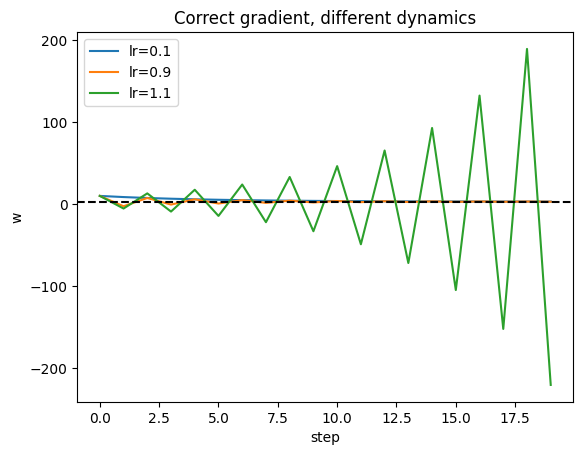

In [80]:
# L(w) = (w - w_star)^2
w_star = 3.0

def loss(w):
    return (w - w_star) ** 2

def grad(w):
    return 2 * (w - w_star)

def run(lr, steps=20):
    w = 10.0
    traj = []
    for _ in range(steps):
        traj.append(w)
        w = w - lr * grad(w)
    return traj

lrs = [0.1, 0.9, 1.1]
trajectories = {lr: run(lr) for lr in lrs}

for lr, traj in trajectories.items():
    plt.plot(traj, label=f"lr={lr}")

plt.axhline(w_star, linestyle="--", color="black")
plt.legend()
plt.title("Correct gradient, different dynamics")
plt.xlabel("step")
plt.ylabel("w")
plt.show()


**Conclusion**

The gradient is correct in all cases.

Yet:
- lr = 0.1 → convergence
- lr = 0.9 → oscillation
- lr = 1.1 → divergence

Learning fails not because the gradient is wrong,
but because the update dynamics are unstable.


### Q2: What role does step size play beyond speed?

Step size determines the **stability** regime of learning dynamics,
not just convergence speed. But it determines whether the trajectories converge, diverge, or oscillate. it controls how the discrete-time gradient descent approximates continuous gradient flow.


In [81]:
lrs = [0.01, 0.1, 0.5, 1.5]
for lr in lrs:
    traj = run(lr, steps=15)
    print(f"lr={lr}: final w={traj[-1]:.3f}")


lr=0.01: final w=8.275
lr=0.1: final w=3.308
lr=0.5: final w=3.000
lr=1.5: final w=114691.000


**Conclusion:**

Small step sizes → stable but slow

Intermediate step sizes → fast convergence

Large step sizes → instability

The learning rate controls *qualitative behavior*.


### Q3: Why does GD define a discrete-time dynamical system?

Gradient descent defines a discrete-time dynamical system because it is a difference equation, that recursively applies update rule to evolve the system's state over time.

$$
w_{t+1} = w_t - η ∇L(w_t)
$$

We visualize the trajectory as a state evolution.


In [82]:
def run1(lr, steps, init):
    w = init
    traj = [w]
    for _ in range(steps):
        grad = 2 * (w - 1.0)  # or whatever your loss is
        w = w - lr * grad
        traj.append(w)
    return traj

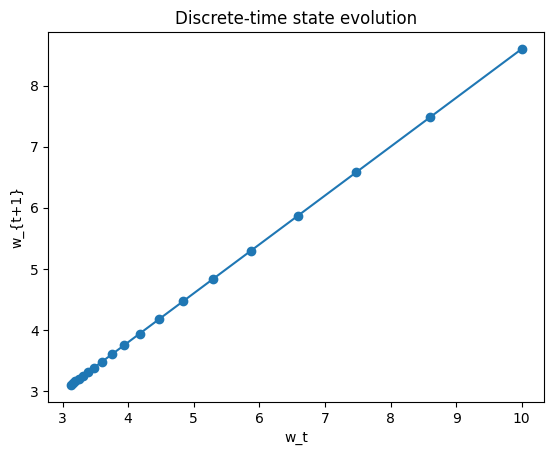

In [83]:

traj = run(lr=0.1, steps=20)

plt.plot(traj[:-1], traj[1:], marker="o")
plt.xlabel("w_t")
plt.ylabel("w_{t+1}")
plt.title("Discrete-time state evolution")
plt.show()


**Conclusion**

Each update maps the current state to the next.

This is a discrete-time dynamical system with fixed points and stability.


### Q4 & Q5: Population symmetry and symmetry breaking

Studying population-level learning dynamics.

- Population symmetry arises when the system architecture is equivariant under permutation of units that is:
  - Symmetry arises when units are initialized identically.
- Symmetry breaks when gradients differ, noise, architectural bottlonecks or reduction operations.

**Experiment**: Symmetric Population

In [84]:
w = Parameter([5.0, 5.0, 5.0])
opt = GD([w], lr=0.1)

def pop_loss(w):
    return sum((wi - 2.0) ** 2 for wi in w.data)

history = []

for _ in range(15):
    L = pop_loss(w)
    for i in range(len(w.data)):
        w.grad[i] = 2 * (w.data[i] - 2.0)
    opt.step()
    history.append(w.data.copy())
    opt.zero_grad()

history


[[4.4, 4.4, 4.4],
 [3.9200000000000004, 3.9200000000000004, 3.9200000000000004],
 [3.5360000000000005, 3.5360000000000005, 3.5360000000000005],
 [3.2288000000000006, 3.2288000000000006, 3.2288000000000006],
 [2.9830400000000004, 2.9830400000000004, 2.9830400000000004],
 [2.7864320000000005, 2.7864320000000005, 2.7864320000000005],
 [2.6291456, 2.6291456, 2.6291456],
 [2.50331648, 2.50331648, 2.50331648],
 [2.402653184, 2.402653184, 2.402653184],
 [2.3221225472, 2.3221225472, 2.3221225472],
 [2.25769803776, 2.25769803776, 2.25769803776],
 [2.206158430208, 2.206158430208, 2.206158430208],
 [2.1649267441664, 2.1649267441664, 2.1649267441664],
 [2.13194139533312, 2.13194139533312, 2.13194139533312],
 [2.105553116266496, 2.105553116266496, 2.105553116266496]]

**Break symmetry**

In [85]:
w = Parameter([5.0, 5.1, 4.9])
opt = GD([w], lr=0.1)

history_asym = []

for _ in range(15):
    for i in range(len(w.data)):
        w.grad[i] = 2 * (w.data[i] - 2.0)
    opt.step()
    history_asym.append(w.data.copy())
    opt.zero_grad()

history_asym


[[4.4, 4.4799999999999995, 4.32],
 [3.9200000000000004, 3.9839999999999995, 3.8560000000000003],
 [3.5360000000000005, 3.5871999999999997, 3.4848000000000003],
 [3.2288000000000006, 3.2697599999999998, 3.1878400000000005],
 [2.9830400000000004, 3.015808, 2.9502720000000004],
 [2.7864320000000005, 2.8126463999999998, 2.7602176000000003],
 [2.6291456, 2.65011712, 2.6081740800000004],
 [2.50331648, 2.520093696, 2.486539264],
 [2.402653184, 2.4160749568, 2.3892314112],
 [2.3221225472, 2.33285996544, 2.31138512896],
 [2.25769803776, 2.266287972352, 2.249108103168],
 [2.206158430208, 2.2130303778816, 2.1992864825344],
 [2.1649267441664, 2.17042430230528, 2.15942918602752],
 [2.13194139533312, 2.136339441844224, 2.127543348822016],
 [2.105553116266496, 2.109071553475379, 2.1020346790576125]]

**Conclusion:**
- Identical initialization → identical trajectories (symmetry).
- Small differences → divergence of roles (symmetry breaking).

Symmetry is a dynamical property, not a coding artifact.


### Q6: Why separate Parameter from Tensor?

- Parameters persist and evolve over time which are the state variable of the learning dynamical system.
- Tensors are intermediate signals in the computational graph.

We demonstrate explicit control over learning.


In [86]:
w = Parameter([1.0])
x = PopulationNode([2.0])

y = w * x  # computation
print("Before step:", w.data)

w.grad = [4.0]
w.step(lr=0.1)

print("After step:", w.data)


Before step: [1.0]
After step: [0.6]


**Conclusion:**
- Learning acts on Parameters, not on intermediate signals.
- This separation makes dynamics explicit and auditable.


### Q7: What does instability mean mathematically?

- Instability means perturbations grow over time. Typically when jacobian of the update maps has eigenvalues with maginitude are equal or greater than 1.
- I test this by perturbing the initial condition.

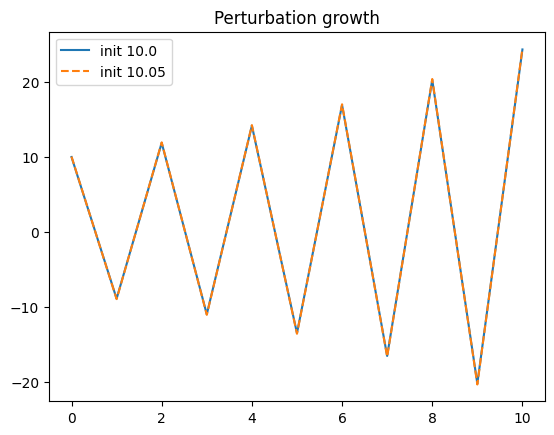

In [87]:
def run(lr, steps, init):
    w = init
    traj = [w]
    for _ in range(steps):
        grad = 2 * (w - 1.0)  # or whatever your loss is
        w = w - lr * grad
        traj.append(w)
    return traj

traj1 = run(lr=1.05, steps=10, init = 10.0)
traj2 = run(lr=1.05, steps=10, init = 10.05)

plt.plot(traj1, label="init 10.0")
plt.plot(traj2, linestyle="--", label="init 10.05")
plt.legend()
plt.title("Perturbation growth")
plt.show()


**Conclusion:**
- Small differences grow over time.
- This is mathematical instability.


### Q8: Why is failure informative? (XOR)
It reveals structural limitations of the system. Whether in representation, learning rule, or dynamics. It informs what must change to make learning possible.

I now demonstrate failure due to representational limits.


**Experiment**: Linear XOR Failure

In [88]:
# XOR dataset
X = [(0,0),(0,1),(1,0),(1,1)]
Y = [0,1,1,0]

# Linear model y = w1*x1 + w2*x2
w = Parameter([0.1, 0.1])
opt = GD([w], lr=0.1)

def predict(x):
    return w.data[0]*x[0] + w.data[1]*x[1]

for epoch in range(20):
    for (x,y) in zip(X,Y):
        y_hat = predict(x)
        err = y_hat - y
        w.grad[0] += err * x[0]
        w.grad[1] += err * x[1]
    opt.step()
    opt.zero_grad()

[w.data, [predict(x) for x in X]]


[[0.3331471513786389, 0.3331471513786389],
 [0.0, 0.3331471513786389, 0.3331471513786389, 0.6662943027572777]]

- The model fails because no linear decision boundary exists.
- Failure reveals representational limits, not optimization issues.


**Final Conclusion**:

- Each theoretical claim in Week 2 is grounded in an explicit experiment.

- This demonstrates understanding of learning as a dynamical system,
not just an optimization routine.
